<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/master/code/1_gan_selection_20_steps_flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
%cd drive/My\ Drive/

[Errno 2] No such file or directory: 'drive/My Drive/'
/content/drive/My Drive


## load data

In [4]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv

# home made
from utils.tools import *

In [5]:
def create_loop():

  a = np.random.uniform(low = 2, high = 5)

  A = np.random.uniform(low = 0.5, high = 1)

  t = np.arange(0, np.pi/a, 0.1)

  x = A * np.sin(a * t) * np.cos(t)
  y = A * np.sin(a * t) * np.sin(t)

  return x, y

In [8]:
### LOOPS

nb_traj = 100
padding = 20
traj = np.zeros((nb_traj, 2, padding))

for i in range(nb_traj):
    x,y = create_loop()

    traj[i,0,:len(x)] = x
    traj[i,1,:len(y)] = y

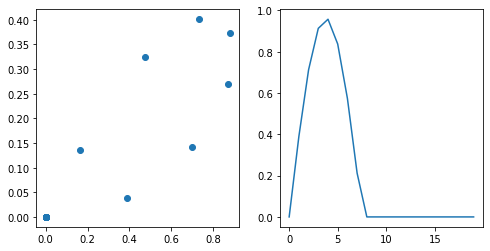

In [9]:
plt.figure(figsize = (8,4))

x = traj[0,0,:]
y = traj[0,1,:]

plt.subplot(1,2, 1)
plt.scatter(x, y)

plt.subplot(1,2, 2)
plt.plot(np.sqrt(x**2 + y**2))

In [10]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        
        self.traj = traj   # save trips
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        sample = self.traj[idx,:]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [11]:
# hyperparameters
batch_size = 20

## reduce size dataset
train_set = TrajDataSet(traj, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [12]:
x =  next(iter(train_loader))

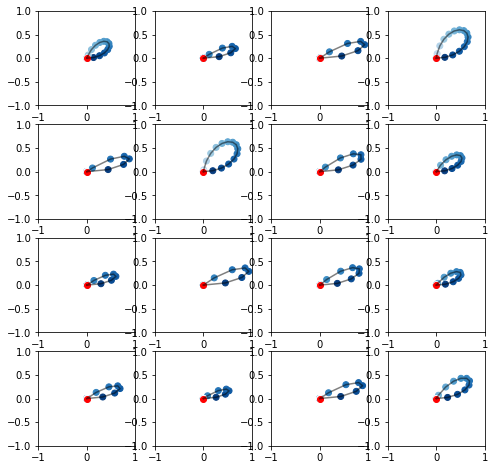

In [13]:
plt.figure(figsize = (8,8))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.plot(x.numpy()[i,0,:], x.numpy()[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(x.numpy()[i,0,:], x.numpy()[i,1,:], c=np.arange(padding), cmap='Blues_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)


## deep networks

Architecture guidelines for stable Deep Convolutional GANs (Radford et al. 2016)

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [14]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## CNN

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(20, 10, kernel_size = 5, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(10),
            nn.ReLU(True),

            nn.ConvTranspose1d(10, 5, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(5),
            nn.ReLU(True),

            nn.ConvTranspose1d(5, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )
        

    def forward(self, z, batch_size):    
        out = self.cnn(z)
        return out

In [17]:
gen = CNNGenerator().to(device)
z = torch.rand((batch_size, padding, 1)).to(device) # (batch, seq, feature)

out = gen(z, batch_size)
out.shape

torch.Size([20, 2, 20])

In [18]:
class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            
            nn.Conv1d(2, 5, kernel_size = 5, stride = 1, padding = 2, bias = False),
            nn.BatchNorm1d(5),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(5, 10, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(10, 20, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(20),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(20, 1, kernel_size=5, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, batch_size):

        out = self.cnn(x)

        return out.squeeze(1)


In [19]:
dis = CNNDiscriminator().to(device)
dis(out, batch_size).shape

torch.Size([20, 1])

In [20]:
sum(p.numel() for p in gen.parameters())

1270

# LSTM

In [21]:
class LSTMGenerator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(1, 16, 1, batch_first=True, bias = True)
        self.linear = nn.Sequential(
                        nn.ReLU(),
                        nn.Linear(16, 16),
                        nn.ReLU(),
                        nn.Linear(16, 2),
                        nn.Tanh()
                      )

    def forward(self, x, batch_size):  

        h_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state
        c_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state

        # init LSTM cells  (batch, seq, feature)
        out, h_n = self.lstm(x, (h_0, c_0))
        out = self.linear(out)
        out = out.view(batch_size, 2, padding)
        return torch.cumsum(out, 2)

In [22]:
gen = LSTMGenerator().to(device)
z = torch.rand((batch_size, padding, 1)).to(device) # (batch, seq, feature)

out = gen(z, batch_size)
out.shape

torch.Size([20, 2, 20])

In [23]:
sum(p.numel() for p in gen.parameters())

1522

In [24]:
class LSTMDiscriminator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(2, 16, 1, batch_first=True)
        
        self.linear = nn.Sequential(
                        nn.Linear(16, 16),
                        nn.ReLU(),
                        nn.Linear(16, 1),
                        nn.Tanh()
                      )

    def forward(self, x, batch_size):  

        h_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state
        c_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #internal stat

        # init LSTM cells  (batch, seq, feature)
        out = x.view(batch_size, padding, 2)
        out, (h_n, c_n) = self.lstm(out, (h_0, c_0))
        out = self.linear(out)
        out = 1/(1 + torch.exp(-torch.mean(out, 1)))

        return out

In [25]:
dis = LSTMDiscriminator().to(device)
dis(out, batch_size).shape

torch.Size([20, 1])

In [26]:
class GAN :
  """
  This class creates a GAN with: 
   - a Generator network 
   - a Discriminator network
   - a Dataloader object from pytorch
  """
  def __init__(self, generator, discriminator, train_loader, device):
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)
    self.device = device
    self.train_loader = train_loader
    
  def train(self, nb_epoch, lr, device):
    """
    This function trains the GAN for nb_epoch with a fiwed learning rate lr
    """                                                       
    criterion = nn.BCELoss()
    optim_d = optim.Adam(discriminator.parameters(), lr= lr, betas=(0.5, 0.999))
    optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))
    score = []

    time_start = time.perf_counter()
    for epoch in range(nb_epoch):
        i = 0

        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for _, x in enumerate(self.train_loader):

            batch = x.shape[0]
            
            target_ones = torch.ones((batch, 1), device=self.device)
            target_zeros = torch.zeros((batch, 1), device=self.device)
            
            i+= 1
            #### TRAIN DISCRIMINATOR
            ## true samples
            x = x.to(device)

            self.discriminator.zero_grad()
            pred_real = self.discriminator(x, batch)
            loss_real = criterion(pred_real, target_ones)

            ## false samples
            seq_length =  x.shape[2]
            z = torch.rand((batch, seq_length, 1), device=self.device)
            with torch.no_grad():
                fake_samples = self.generator(z, batch)
            pred_fake = self.discriminator(fake_samples, batch)
            loss_fake = criterion(pred_fake, target_zeros)
            
            # combine
            loss = (loss_real + loss_fake) / 2
            loss.backward()
            optim_d.step()

            loss_d_real_running += loss_real.item()
            loss_d_fake_running += loss_fake.item()
            
            #### TRAIN GENERATOR
            self.generator.zero_grad()
            z = torch.rand((batch, seq_length, 1), device=self.device) 

            generated = self.generator(z, batch)
            classifications = self.discriminator(generated, batch)
            loss = criterion(classifications, target_ones) #+ 0.1 * torch.sum((generated[:,0, 0] - generated[:,0,-1])**2)
            loss.backward()
            optim_g.step()

            loss_g_running += loss.item()

        if epoch%100 == 0:
          traj_sim = self.test(100)
          score.append(get_score(traj, traj_sim))
       
        if epoch%500 == 0:
          print('Epoch [{}/{}] -----------------------------------------------------------------------------'
              .format(epoch+1, nb_epoch, i, len(self.train_loader)))
          print('G: {}, Dr : {}, Df : {}'
              .format(loss_g_running/batch, loss_d_real_running/batch, loss_d_fake_running/batch))
          
          self.plot()


    #run your code
    self.score = score
    self.computation_time = (time.perf_counter() - time_start)

  def test(self, nb):
    """
    This function generates nb trajectories
    """ 
    self.generator.zero_grad()    

    x =  next(iter(self.train_loader))
    seq_length = x.shape[2]

    z = torch.rand((nb, seq_length, 1), device=self.device)
    generated = self.generator(z, nb)
    traj_sim = generated.cpu().detach().numpy()
    return traj_sim

  def plot(self):
    """
    This function plots few trajectories
    """ 
    traj_sim = self.test(16)

    plt.figure(figsize = (8,8))
    for i in range(16):
      plt.subplot(4,4,i+1)
      plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
      plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
      plt.scatter(0,0, c = 'red')
      plt.xlim(-1,1)
      plt.ylim(-1,1)

    plt.show()
    plt.close()

  def save(self, name):
    """
    This function save models
    """ 
    torch.save(self.generator, name+'_G.pt')
    torch.save(self.discriminator, name+'_D.pt')

In [27]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# CNN - CNN

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.1615498811006546, Dr : 0.14856851398944854, Df : 0.18791511356830598


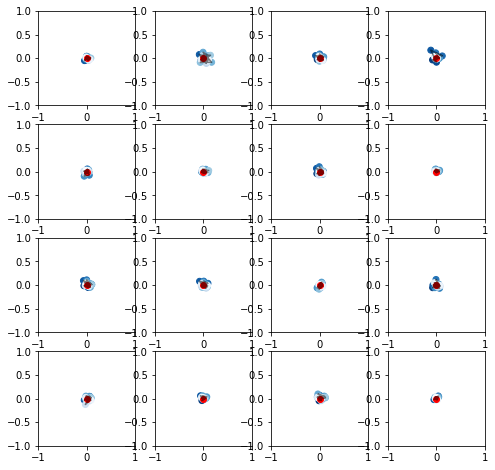

Epoch [501/5000] -----------------------------------------------------------------------------
G: 1.5114741802215577, Dr : 0.00025466270453762264, Df : 0.0006190304062329233


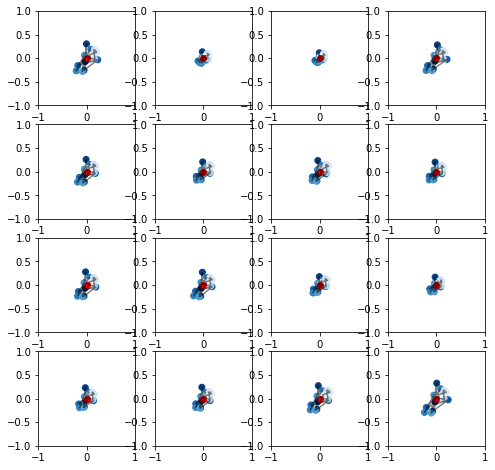

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.8847163558006287, Dr : 0.0067610522266477345, Df : 0.0058653708547353745


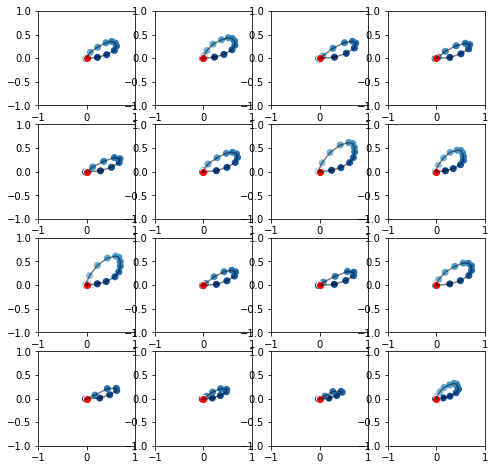

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 1.1405410766601562, Dr : 0.0015269302995875478, Df : 0.005135552911087871


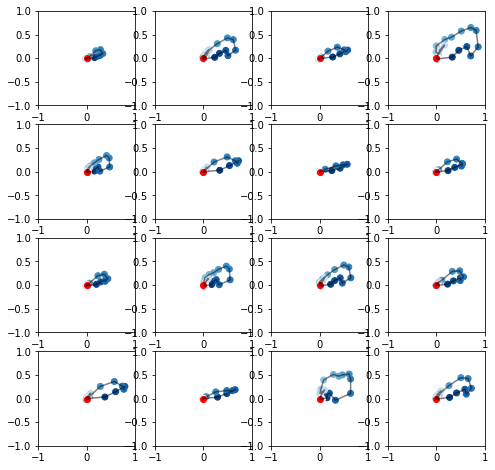

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 1.9287653923034669, Dr : 0.000117940480413381, Df : 0.00015624744119122625


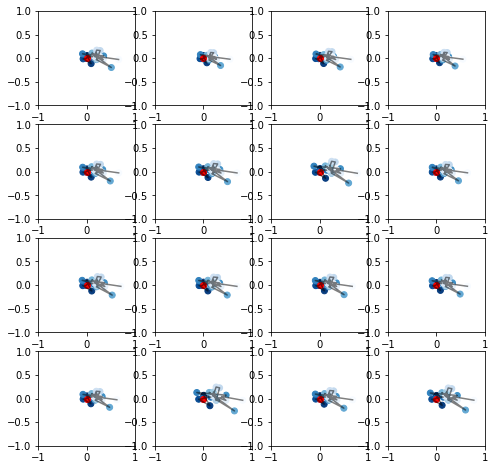

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 1.2507988452911376, Dr : 0.001689010253176093, Df : 0.0026483099441975354


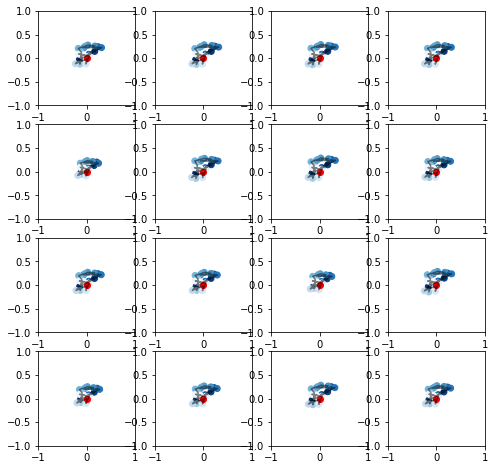

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 1.4237119436264039, Dr : 0.001141987438313663, Df : 0.0012548239203169942


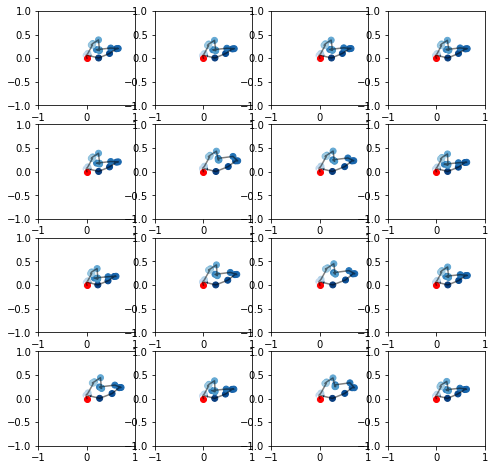

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 1.589289665222168, Dr : 0.0021101918624481185, Df : 0.0010302452399628236


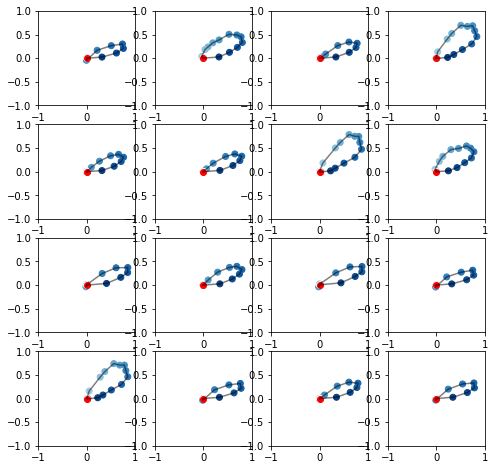

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 1.3309976577758789, Dr : 0.005448526633699657, Df : 0.004288123617880046


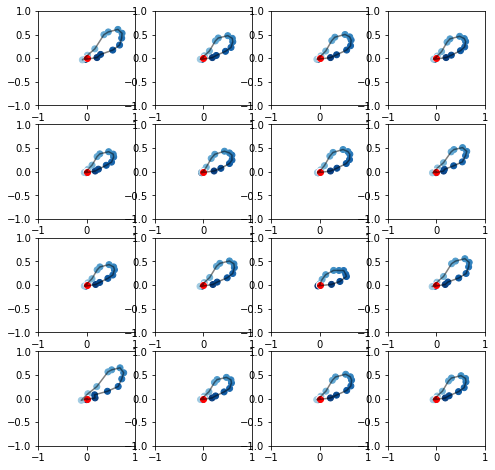

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 1.4644969701766968, Dr : 0.0015275647398084401, Df : 0.0007301838006242179


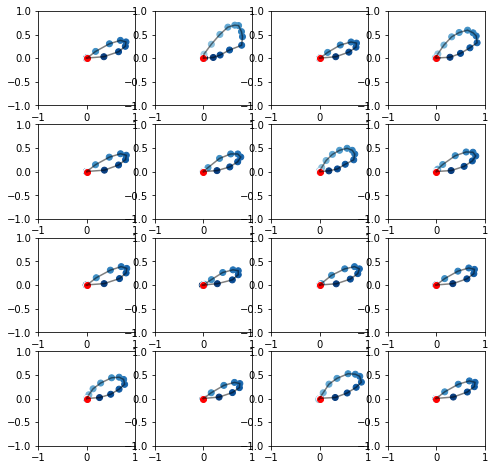

In [28]:
generator = CNNGenerator()
discriminator = CNNDiscriminator()

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

cnn_cnn = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

cnn_cnn.train(nb_epoch, lr, device)

# LSTM - LSTM


Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.15905971229076385, Dr : 0.15870763659477233, Df : 0.18831225335597992


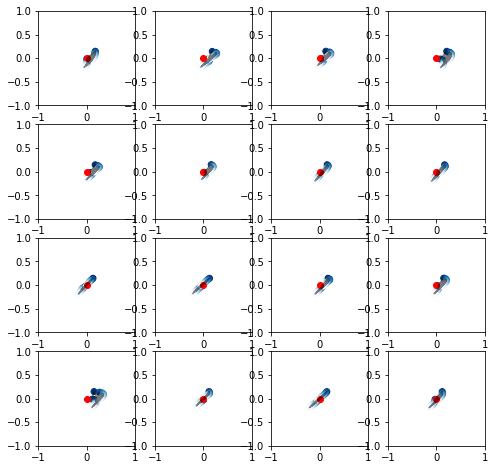

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.17446483671665192, Dr : 0.17241414189338683, Df : 0.1725115567445755


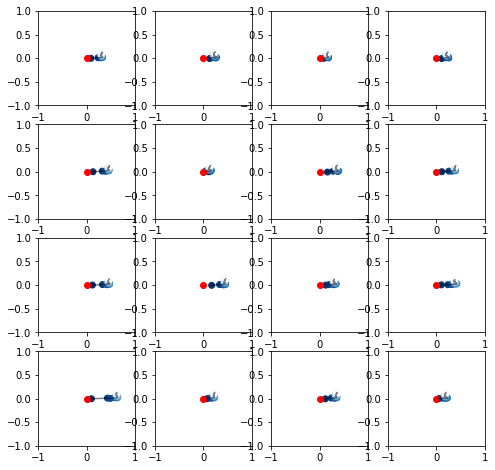

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.24594090282917022, Dr : 0.11647688001394271, Df : 0.12051179409027099


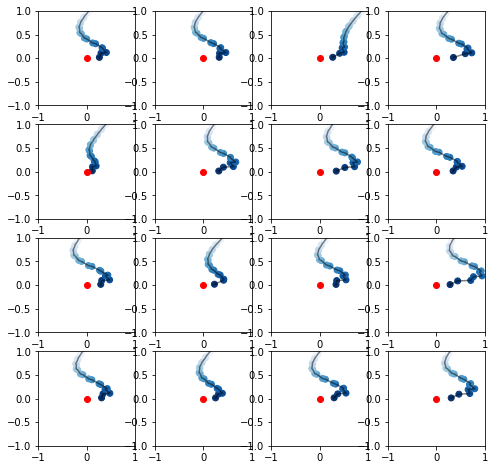

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.26577733755111693, Dr : 0.11131007075309754, Df : 0.11076990514993668


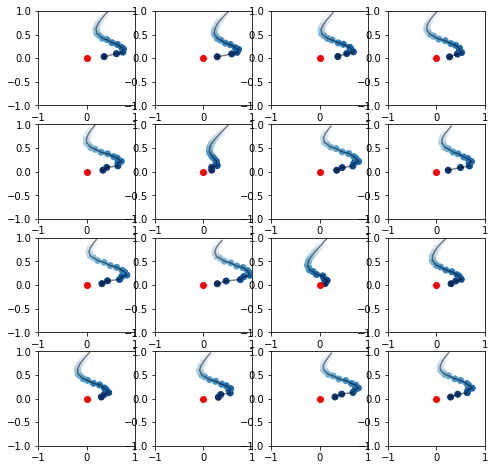

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.26621994972229, Dr : 0.10311568677425384, Df : 0.10338277518749237


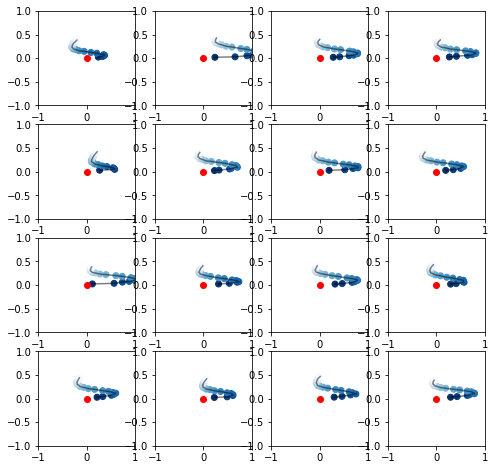

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.2705752968788147, Dr : 0.10132475346326827, Df : 0.1016356572508812


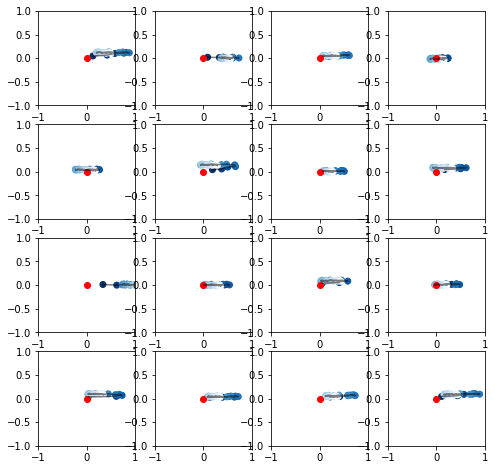

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.28019432425498964, Dr : 0.10115048736333847, Df : 0.10159114003181458


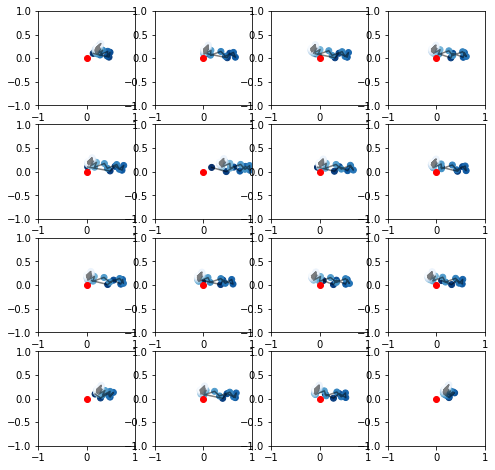

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.2922619223594666, Dr : 0.10708337128162385, Df : 0.09210073500871659


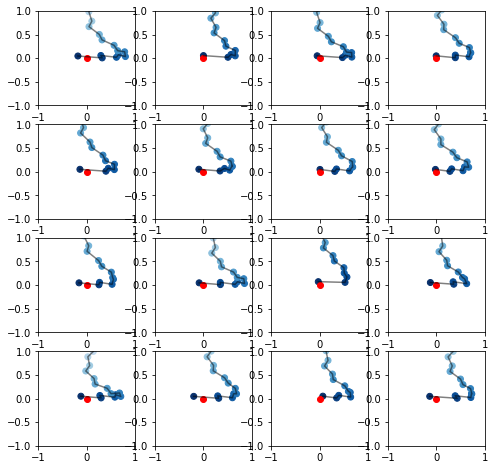

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.30165799260139464, Dr : 0.10462112724781036, Df : 0.0909128651022911


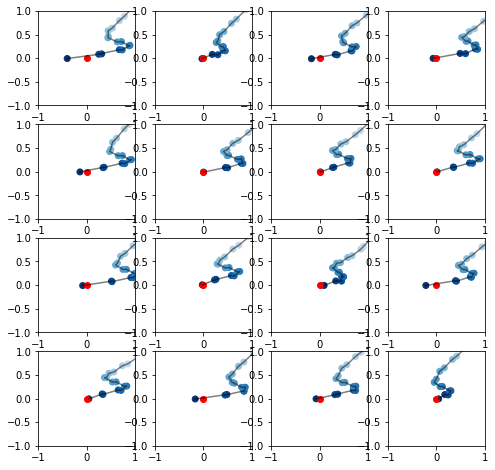

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.30079700946807864, Dr : 0.10680411010980606, Df : 0.09017682075500488


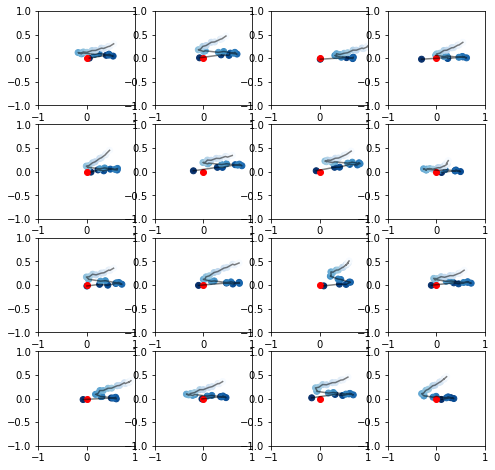

In [29]:
generator = LSTMGenerator().to(device)
discriminator = LSTMDiscriminator().to(device)

# ### WEIGHT INITIALIZATION
# generator.apply(weights_init)
# discriminator.apply(weights_init)

lstm_lstm = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

lstm_lstm.train(nb_epoch, lr, device)

# LSTM - CNN

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.1895586609840393, Dr : 0.1448916107416153, Df : 0.1636902153491974


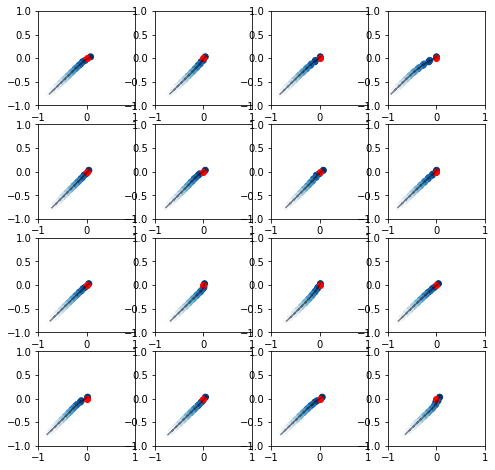

Epoch [501/5000] -----------------------------------------------------------------------------
G: 1.7433303594589233, Dr : 0.00020138986583333461, Df : 0.0002713842317461967


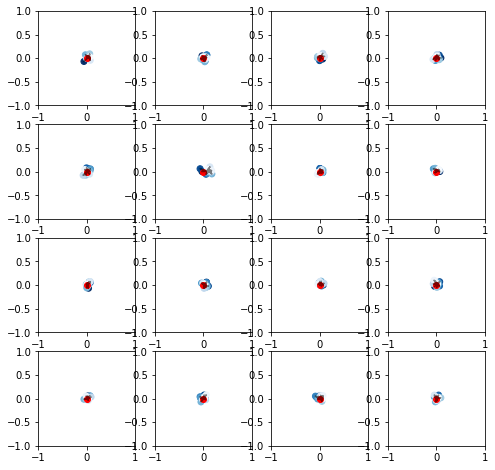

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 2.209163761138916, Dr : 3.438768035266548e-05, Df : 4.6411941002588716e-05


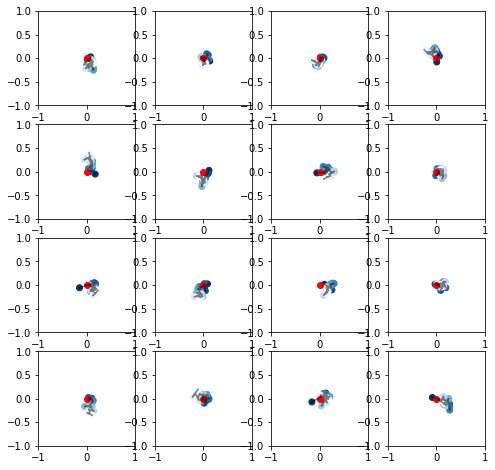

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 2.607713508605957, Dr : 7.919222571217688e-06, Df : 9.547642184770666e-06


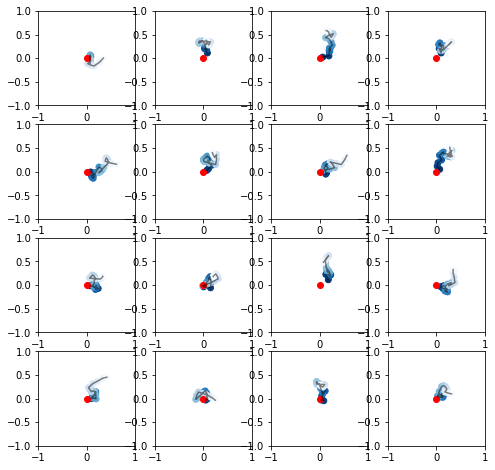

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 2.2561201095581054, Dr : 0.00013618337106890976, Df : 0.00028882503538625316


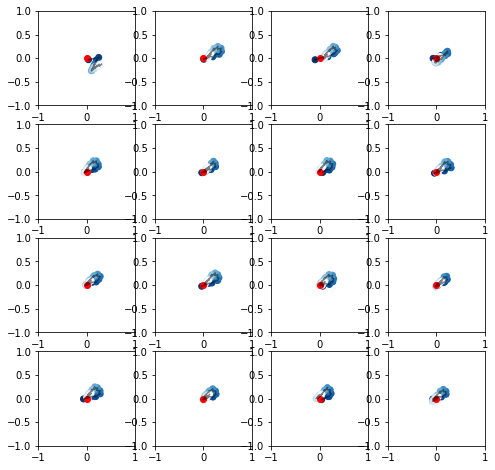

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 2.682416391372681, Dr : 5.819812577101402e-06, Df : 1.2810754924430512e-05


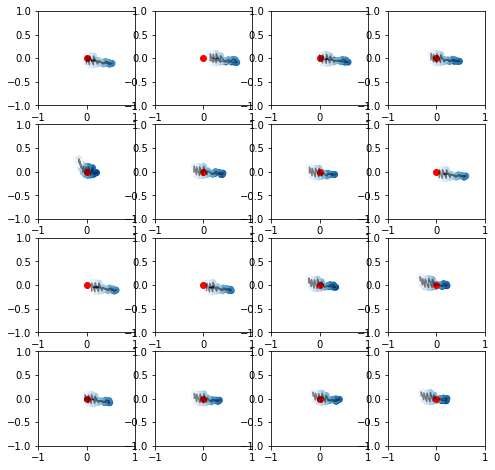

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 3.2844005584716798, Dr : 1.7133453184214887e-06, Df : 1.8534218270360726e-06


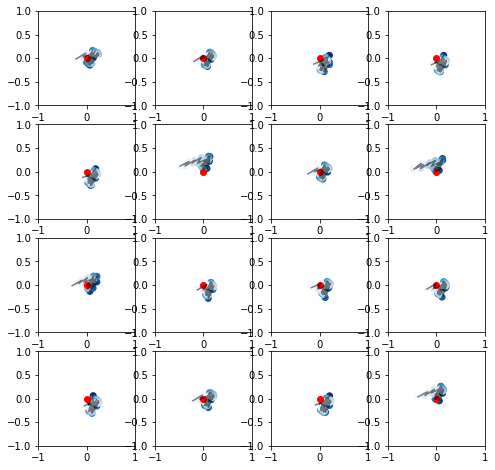

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 2.552932691574097, Dr : 2.50766299359384e-05, Df : 4.191629122942686e-05


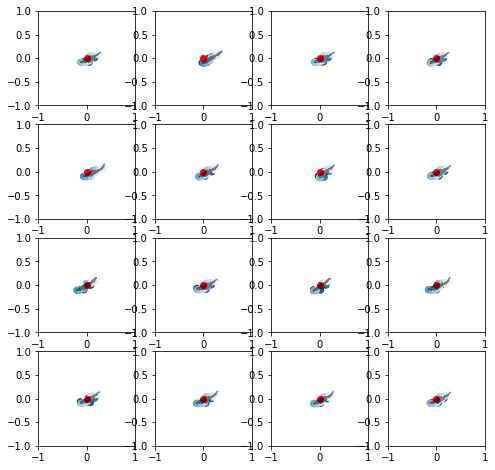

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 2.85311279296875, Dr : 2.3577664978802205e-05, Df : 5.782540720247198e-05


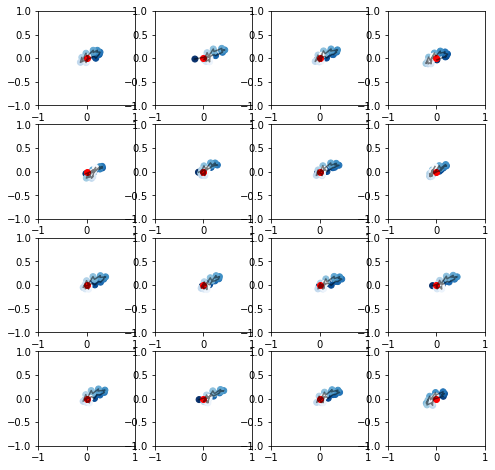

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 2.329576110839844, Dr : 4.2706339991127605e-05, Df : 8.593333477620035e-05


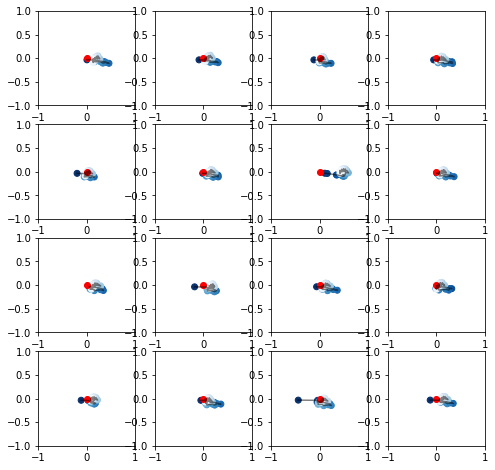

In [30]:
generator = LSTMGenerator().to(device)
discriminator = CNNDiscriminator().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

lstm_cnn = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

lstm_cnn.train(nb_epoch, lr, device)

# CNN - LSTM

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.16190418601036072, Dr : 0.16199866831302642, Df : 0.18535331785678863


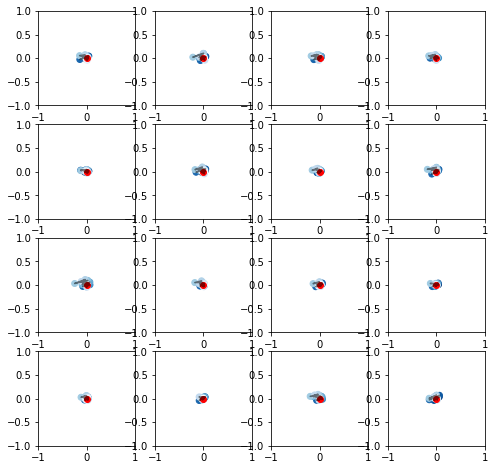

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.17326813638210298, Dr : 0.1732748568058014, Df : 0.17315300703048705


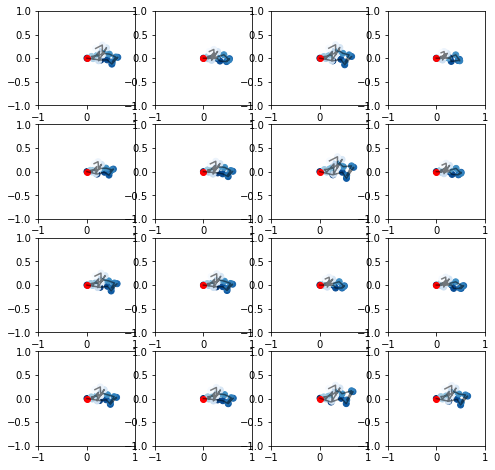

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.1734204947948456, Dr : 0.17322351336479186, Df : 0.17322966754436492


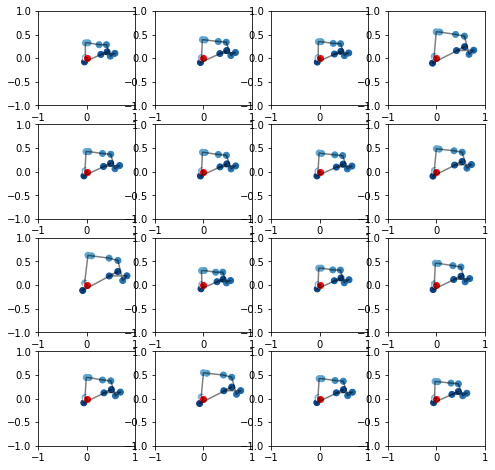

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.17336427867412568, Dr : 0.17349843978881835, Df : 0.17333747148513795


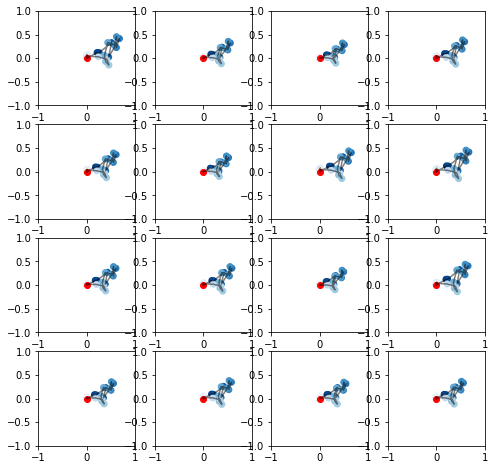

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.1730370044708252, Dr : 0.17315008044242858, Df : 0.1733933687210083


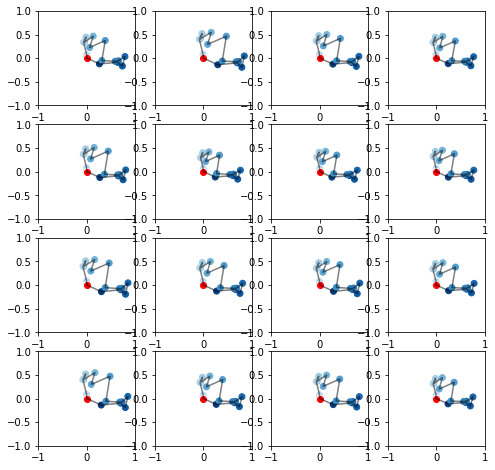

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.17321057617664337, Dr : 0.17329089641571044, Df : 0.17330925166606903


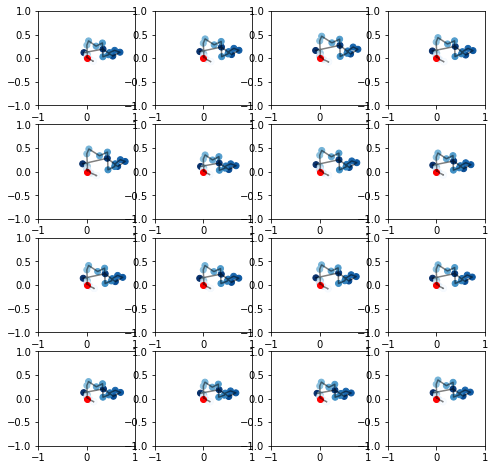

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.17332893311977388, Dr : 0.17331654727458953, Df : 0.17320017218589784


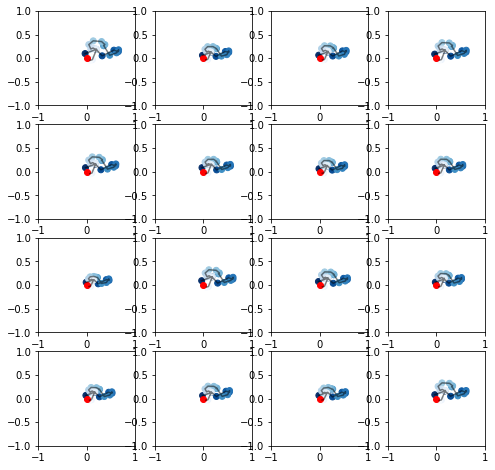

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.17341275811195372, Dr : 0.1732529103755951, Df : 0.173157799243927


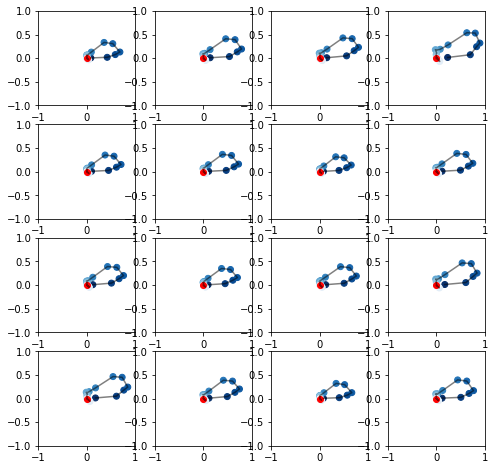

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.17332278490066527, Dr : 0.1733437478542328, Df : 0.17324953973293306


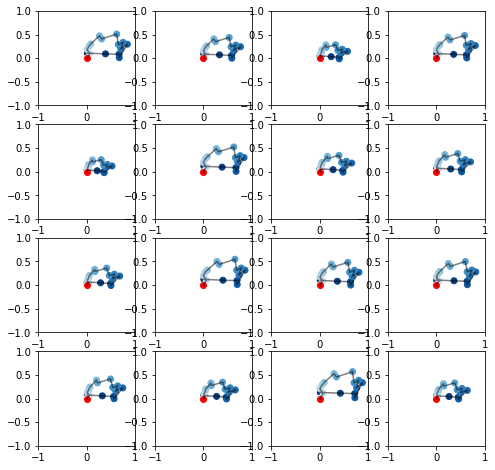

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.17323408424854278, Dr : 0.1733367323875427, Df : 0.17332347333431244


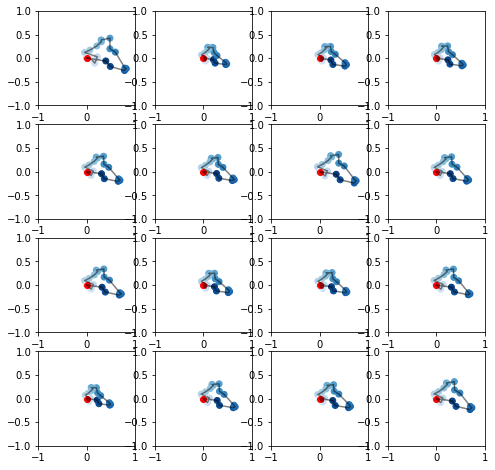

In [31]:
generator = CNNGenerator().to(device)
discriminator = LSTMDiscriminator().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

cnn_lstm = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

cnn_lstm.train(nb_epoch, lr, device)

# RESULTS

Text(0, 0.5, 'Score')

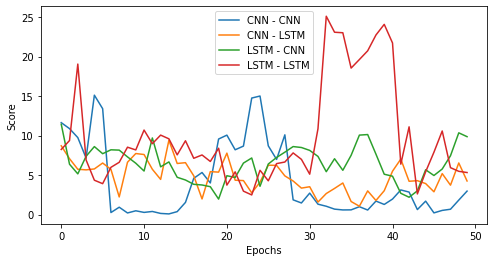

In [32]:
plt.figure(figsize=(8,4))
plt.plot(cnn_cnn.score, label = "CNN - CNN")
plt.plot(cnn_lstm.score, label = "CNN - LSTM")
plt.plot(lstm_cnn.score, label = "LSTM - CNN")
plt.plot(lstm_lstm.score, label = "LSTM - LSTM")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')

In [36]:
score = np.array([cnn_cnn.score, cnn_lstm.score, lstm_cnn.score, lstm_lstm.score])
with open('score_20_steps_flower.npy', 'wb') as f:
    np.save(f, score)

<BarContainer object of 4 artists>

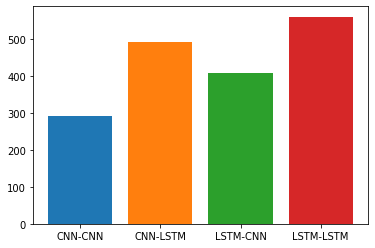

In [33]:
plt.bar(x = ['CNN-CNN', 'CNN-LSTM', 'LSTM-CNN', 'LSTM-LSTM'], 
        height = [cnn_cnn.computation_time, cnn_lstm.computation_time, lstm_cnn.computation_time,lstm_lstm.computation_time],
        color = [dicolour['blue'], dicolour['orange'], dicolour['green'], dicolour['red']])

In [37]:
time = np.array([cnn_cnn.computation_time, cnn_lstm.computation_time, lstm_cnn.computation_time,lstm_lstm.computation_time])
with open('computation_time_20_steps_flower.npy', 'wb') as f:
    np.save(f, time)

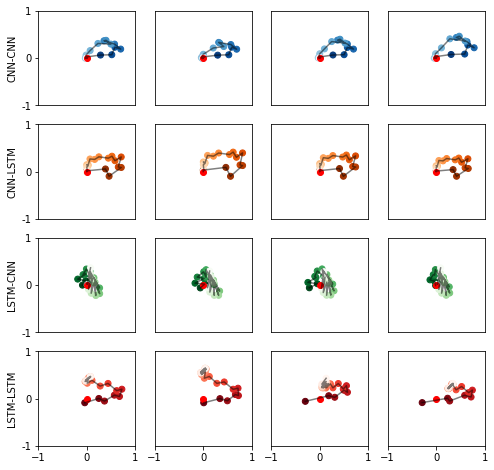

In [34]:
plt.figure(figsize=(8,8))

nb = 4
traj_sim = cnn_cnn.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('CNN-CNN')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)


nb = 4
traj_sim = cnn_lstm.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+4)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Oranges_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('CNN-LSTM')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)

nb = 4
traj_sim = lstm_cnn.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+8)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Greens_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('LSTM-CNN')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)

nb = 4
traj_sim = lstm_lstm.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+12)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Reds_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('LSTM-LSTM')
  ax = plt.gca()
  if i >0:
    ax.axes.yaxis.set_visible(False)

In [35]:
cnn_cnn.save('cnn_cnn_20_steps_flower')
lstm_cnn.save('lstm_cnn_20_steps_flower')
cnn_lstm.save('cnn_lstm_20_steps_flower')
lstm_lstm.save('lstm_lstm_20_steps_flower')